# Análisis y preprocesado de trayectorias

En este programa se analizarán los atributos y posteriormente se procesarán los datos para obtener un conjunto limpio, con atributos relevantes y sin valores vacíos.

Se procesará en este orden:

Análisis de atributos

*   Número de valores no vacíos (count), (isnull())
*   Varianza (var) - Selección de atributos constantes para su posterior eliminación
*   Gráficas de posición del dron (x,y,z)
*   Gráficas de posición (latitud, longitud, altitud)

Análisis de instancias

* Eliminación de filas vacías o con menos de dos datos
* Agrupación de datos con la misma timestamp

Preprocesado

* Eliminación de columnas sin valores 
* Selección y eliminación de atributos irrelevantes y/o constantes
* Eliminación/Filtrado de atributos categóricos (todos son float64 en principio)
* Normalización de datos si es necesario


Librerías usadas: numpy, pandas, matplotlib, seaborn




In [1]:
#IMPORTS

from cmath import nan
import math
import time
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp

#PATHS
folder="Quadrotor"
mypath= r"/content/drive/MyDrive/TFG/DATASETS/"+folder+"/"
#outputPath = r"/content/drive/MyDrive/TFG/Preprocessed/DATA/"
#otherPath = r"/content/drive/MyDrive/TFG/others/"
instance = r'0444d554-8057-4802-b13f-36705dd44a3c.csv'

path=r"/content/drive/MyDrive/TFG Celia/Código/Datos_limpios/Datos_sin_RDP/"
mypath= path+"/"+folder+"/"


#r'2134bbee-9fa4-4b1d-8628-af04c3262b0e.csv' #buena
#r'0c77354b-b606-4ca2-9897-a5a5089b75b7.csv' #buena
#r'0b15468e-eaf6-44b4-b45f-746982bd125b.csv' #buena
#r'0daa9554-fa61-4700-8af0-1ea4fe689242.csv' #no es buena
#r'0cec11f1-d18c-42e7-98a3-7db159d31564.csv'
# r'00d65b8f-b2b8-4db8-a2a8-2d5bde060948.csv'
#r'27c80bd3-0475-46cb-a04b-38254286273c.csv'
#r'000bfcbb-2cbf-4b0f-8cbf-e534c58e8c7a.csv'
#r"00b2e3b7-5162-43fd-a895-5de7ccc02c31.csv"

In [4]:
for f in listdir(path): 
  if isfile(join(path, f)):
    instance = str(f)
    df = pd.DataFrame() #CLEAN DF
    df = pd.read_csv(mypath+instance,sep=',')
    model_list1 = pd.read_csv(path+str(f),sep=',')
    model_list = pd.concat([model_list,model_list1])

In [ ]:
#FILES - INSTANCES - COLUMN NAMES

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] #FILE NAMES
onlynames = [f[:36].replace('.csv','') for f in listdir(mypath) if isfile(join(mypath, f))] #INSTANCE NAMES
onlyattributes = [f[36:].replace('.csv','') for f in listdir(mypath) if isfile(join(mypath, f))] #COLUMN NAMES


In [ ]:
df = pd.DataFrame() #CLEAN DF
df = pd.read_csv(path+instance,sep=',')

df_model=df['drone_model']

df_model[0]

In [ ]:
#Dataframe raw
pd.set_option('max_rows', len(df)) #To see the whole dataframe

#df

##Eliminación de columnas vacías

Existen varias columnas que no contienen ningún valor. Se eliminan con df.drop()

In [ ]:
#DROP COLUMNS THAT HAVE 0 VALUES

for col in df.columns:
    if len(df[col].value_counts()) == 0:
      #print(col)
      df=df.drop(columns=col)

#df

##Análisis de las varianzas

Una varianza nula mostrará que ese atributo es constante. Se vuelve a usar df.drop() con las columnas que tengan varianza 0, y se mostrará el número de valores que tiene cada columna.

In [ ]:
#df.var()

##Atributos que pueden ser de interés:

Aquellos que muestren el estado del dron:
(ground_contact, maybe_landed, landed)    : llenas de NAN, no parecen útiles

nombres de aceleraciones: acc_x, acc_y acc_z o ax,ay,az

actuator outputs(output[0]): señales de saturación
https://docs.px4.io/master/en/log/flight_review.html#actuator-outputs

output_tracking_error

lon, lat, alt : No aparecen durante toda la trayectoria,por lo que no la definen. Con los parámetros x, y z ya vale. 

vel_m_s : lleno de NAN
temperatura del dron (temperature): lleno de NAN
carga (load) : lleno de NAN

failure_detector_status

engine failure

In [ ]:
for col in df.columns:
    if df[col].var() == 0 and col!='drone_model' and col!='x' and col!='y' and col!='z': #if one dimension is = 0
      #print(col,df[col].count())
      df=df.drop(columns=col)

df

##Análisis de las posiciones x, y, z

Es un paso muy importante, observar que la trayectoria sea consistente y no haya posiciones fuera de lo normal.

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

x = df['x']
y = df['y']
z = df['z']

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
plt.show()

In [ ]:
#Dataframe with some basic attributes to analyze: TAKE ONLY USEFUL COLUMNS SUCH AS X,Y,Z POSITIONS, THEIR REFERENCE AND VELOCITIES

base_df = pd.DataFrame(df, columns=["timestamp","x","y","z","vx","vy","vz","ax","ay","az",'roll','pitch','yaw','drone_model'])
base_df=base_df.dropna(axis=0,thresh=3) #NEEDS AT LEAST A TIMESTAMP AND A VALUE
base_df.drop_duplicates()

base_df

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
aggregation_functions = {'x': 'first','y': 'first','z': 'first','vx': 'first','vy': 'first','vz': 'first','ax': 'first','ay': 'first','az': 'first','drone_model':'first'}
df_new = df.groupby(df['timestamp']).aggregate(aggregation_functions)

#data = data.fillna('')

df_new.dropna(inplace=True)

df_new

,x,y,z,vx,vy,vz,ax,ay,az,drone_model
timestamp,,,,,,,,,,
20385519.0,-0.003937,-0.000567,0.170239,-0.002403,0.005109,0.033876,-0.465768,-1.411054,-0.268410,4011.0
20489523.0,-0.004117,-0.000456,0.172361,-0.001208,0.010547,0.036327,-0.060777,0.101728,0.176430,4011.0
20585515.0,-0.003120,-0.000198,0.175044,-0.000492,0.011441,0.031642,-0.507670,-0.023210,-0.448860,4011.0
20690319.0,-0.000701,-0.000485,0.177228,0.003501,0.012725,0.032098,0.277583,0.648711,0.633828,4011.0
20794325.0,0.003693,-0.001706,0.176394,0.007143,0.009300,0.029793,0.102017,0.262626,0.268556,4011.0
20890313.0,0.007400,-0.003342,0.171132,0.010298,0.008470,0.021277,0.185380,0.382999,-0.261379,4011.0
20994326.0,0.011008,-0.005566,0.168687,0.014555,0.004362,0.018962,-0.013545,-0.138700,0.045038,4011.0
21099123.0,0.014806,-0.008341,0.173116,0.014942,0.003120,0.021525,-0.671042,0.608661,-0.105673,4011.0
21195128.0,0.018313,-0.011169,0.175061,0.018312,-0.000040,0.017218,-0.565767,-0.134874,-0.936239,4011.0


##Limpieza de trayectoria

EN la siguiente celda, se observa la trayectoria "final" tras eliminar puntos que no aportaban información

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

x = df_new['x']
y = df_new['y']
z = df_new['z']

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

##Análisis de rangos de desplazamiento

Con boxplots, se observará el rango del movimiento del dron en cada coordenada x,y,z.

{'boxes': [<matplotlib.lines.Line2D at 0x7fd86b9e0a90>],
 'caps': [<matplotlib.lines.Line2D at 0x7fd86b9cc450>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd86b9fa490>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fd86b9ccf10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fd86b9df650>,
  <matplotlib.lines.Line2D at 0x7fd86b9dfb90>]}

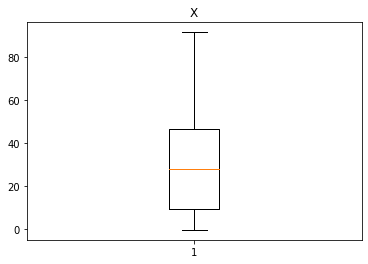

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('X')
ax1.boxplot(df_new['x'])

{'boxes': [<matplotlib.lines.Line2D at 0x7fd86b9bcd10>],
 'caps': [<matplotlib.lines.Line2D at 0x7fd86b9b4710>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd86b9a38d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fd86b9a3350>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fd86b98cc50>,
  <matplotlib.lines.Line2D at 0x7fd86b9b41d0>]}

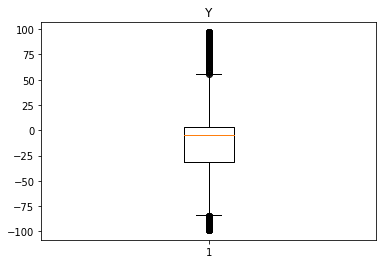

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('Y')
ax1.boxplot(df_new['y'])

{'boxes': [<matplotlib.lines.Line2D at 0x7fd86b8efad0>],
 'caps': [<matplotlib.lines.Line2D at 0x7fd86ba3f810>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd86ba2a850>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fd86ba2a310>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fd86b8ddd50>,
  <matplotlib.lines.Line2D at 0x7fd86ba3f2d0>]}

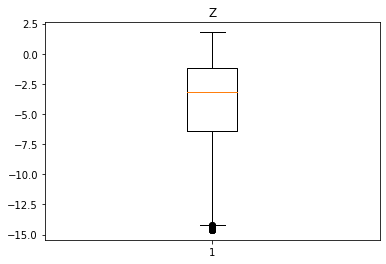

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('Z')
ax1.boxplot(df_new['z'])

##Análisis de correlación

Se muestran todas las combinaciones de atributos y sus gráficas. Lo más destacable es las relaciones entre las velocidades vx,vy,vz y la distribución de puntos de estas velocidades respecto a la timestamp.

In [ ]:
base_df.dropna()

base_df.groupby('timestamp').describe()
import seaborn as sns
sns.pairplot(base_df)

In [ ]:
df_new.dropna()

df_new.groupby('timestamp').describe()
import seaborn as sns
sns.pairplot(base_df)

Output hidden; open in https://colab.research.google.com to view.

##Análisis de instancias/filas

Eliminación de filas vacías o con menos de dos datos y posibles duplicados 

In [ ]:

df.dropna(axis=0,thresh=2) #NEEDS AT LEAST A TIMESTAMP AND A VALUE
#df.dropna(axis=1, thresh=1)
df = df.drop_duplicates()

df

In [ ]:
x = df['vx']
y = df['vy']
z = df['vz']

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax=fig.add_subplot(111,projection='3d')

# to rotate the axes and update.
for angle in range(0,360): 
    ax.view_init(30,angle)
ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
plt.show()

In [ ]:
#SAVE THE DATAFRAME IN A CSV

df.to_csv(outputPath+instance)     

In [ ]:
#DROP NULL ROWS

bool_series = pd.isnull(df['timestamp'])

df[bool_series]

In [ ]:
df['drone_model']

In [ ]:
pd.set_option('max_rows', len(df)) 

df.isna().sum() #number of NAN values of every column
df.count() #number of values of every column

with open('/content/drive/MyDrive/TFG/Preprocessed/count.txt', 'w') as f:
    f.write(str(df.count()))
with open('/content/drive/MyDrive/TFG/Preprocessed/listNAN.txt', 'w') as f:
    f.write(str(df.isna().sum()))

In [ ]:
for col in df.columns:
    print(col)

In [ ]:
# making data frame from csv file
  
# making new data frame with dropped NA values
new_data = df.dropna(axis = 0, thresh=2)
  
# comparing sizes of data frames
print("Old data frame length:", len(df), "\nNew data frame length:", 
       len(new_data), "\nNumber of rows with at least 2 NA value: ",
       (len(df)-len(new_data)))

Old data frame length: 130371 
New data frame length: 130370 
Number of rows with at least 2 NA value:  1


In [ ]:
df_new

,x,y,z,vx,vy,vz,ax,ay,az,drone_model
timestamp,,,,,,,,,,
20385519.0,-0.003937,-0.000567,0.170239,-0.002403,0.005109,0.033876,-0.465768,-1.411054,-0.268410,4011.0
20489523.0,-0.004117,-0.000456,0.172361,-0.001208,0.010547,0.036327,-0.060777,0.101728,0.176430,4011.0
20585515.0,-0.003120,-0.000198,0.175044,-0.000492,0.011441,0.031642,-0.507670,-0.023210,-0.448860,4011.0
20690319.0,-0.000701,-0.000485,0.177228,0.003501,0.012725,0.032098,0.277583,0.648711,0.633828,4011.0
20794325.0,0.003693,-0.001706,0.176394,0.007143,0.009300,0.029793,0.102017,0.262626,0.268556,4011.0
20890313.0,0.007400,-0.003342,0.171132,0.010298,0.008470,0.021277,0.185380,0.382999,-0.261379,4011.0
20994326.0,0.011008,-0.005566,0.168687,0.014555,0.004362,0.018962,-0.013545,-0.138700,0.045038,4011.0
21099123.0,0.014806,-0.008341,0.173116,0.014942,0.003120,0.021525,-0.671042,0.608661,-0.105673,4011.0
21195128.0,0.018313,-0.011169,0.175061,0.018312,-0.000040,0.017218,-0.565767,-0.134874,-0.936239,4011.0
